In [1]:
import numpy as np
import pyproj
import glob
import datetime
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
np.float = float

### load grid

In [2]:
def WGS84toEASE2(lon, lat):
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x , y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

file='/Users/carmennab/cpom_server//home/gch/SS_budget_23/grids_S/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)
lon = npzfile["lons"]
lat = npzfile["lats"]
grid_x, grid_y = WGS84toEASE2(lon, lat)

In [3]:
datapath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/2024-08-15/data_out_smoothed/'
files = sorted(glob.glob(datapath+'*.nc'))

In [4]:
all_budgets = [] 

for file in files:
    start_date_str = file.split('/')[9].split('_')[1].split('--')[0]
    start_date = datetime.datetime.strptime(start_date_str,"%Y%m%d").date()

    data = Dataset(file)

    intensification = np.array(data['intensification']) * 86400
    advection = np.array(data['advection']) * 86400
    divergence = np.array(data['divergence']) * 86400
    residual = np.array(data['residual']) * 86400
    ice_drift_x = np.array(data['ice_drift_x']) 
    ice_drift_y = np.array(data['ice_drift_y']) 

    b = {'year':start_date.year,'month':start_date.month,'intensification':intensification,'advection':advection,
        'divergence':divergence,'residual':residual,'ice_drift_x':ice_drift_x,'ice_drift_y':ice_drift_y}

    all_budgets.append(b)
    
### create dataframe of all budgets
all_budgets = pd.DataFrame(all_budgets).sort_values(['month','year'])

In [15]:
seasons = ['summer (NDJ)','autumn (FMA)','winter (MJJ)','spring (ASO)']
season_months = [[11,12,1],[2,3,4],[5,6,7],[8,9,10]]

In [16]:
budget_terms = ['intensification','advection','divergence','residual','ice_drift_x','ice_drift_y']

climatologies_all = {}

for season, months in zip(seasons,season_months):

    climatologies = {}
    
    season_data = all_budgets[np.isin(all_budgets['month'],months)]

    for term in budget_terms:
        climatologies[term] = np.nanmean(np.array([data for data in season_data[term]]),axis=0)
        
    climatologies_all[season] = climatologies

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_4278/3914492972.py:12: RuntimeWarning: Mean of empty slice
  climatologies[term] = np.nanmean(np.array([data for data in season_data[term]]),axis=0)


### plot climatology

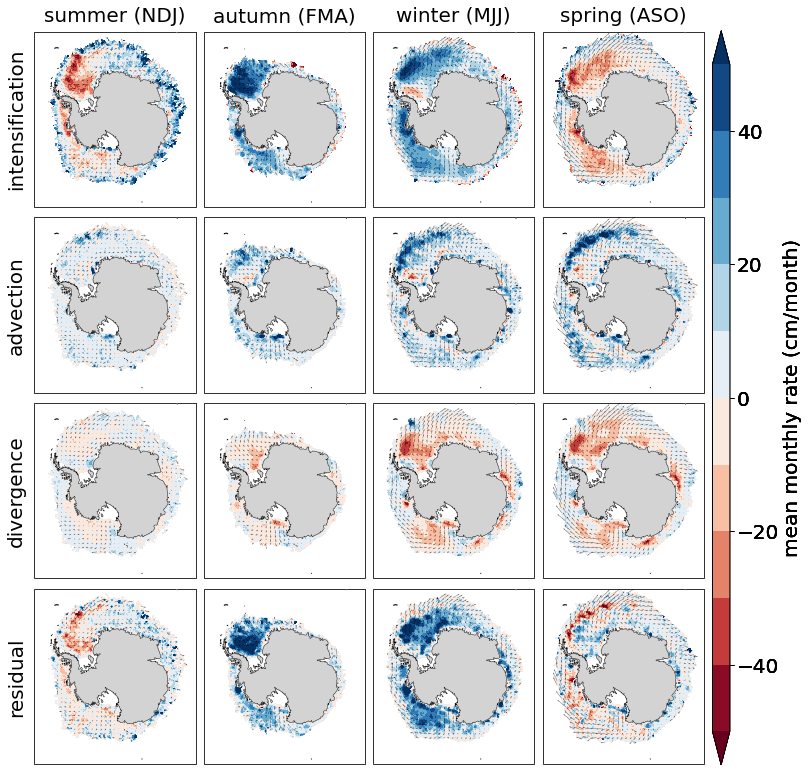

In [17]:
figpath = '/Users/carmennab/Dropbox/michel_csao/figures/'
fig = plt.figure(figsize=(12,13.5))
spec = gridspec.GridSpec(ncols=4, nrows=4, wspace=0.05,hspace=0.05)

c = 0

for term in budget_terms[:4]:
    for season in seasons:
        season_data = climatologies_all[season]
        ax = fig.add_subplot(spec[c],projection=ccrs.SouthPolarStereo())
        ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
        ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
        cmap = ax.contourf(grid_x,grid_y,season_data[term]*100,cmap='RdBu',levels=np.arange(-50,55,10),extend='both')
        ax.quiver(grid_x[::8, ::8], grid_y[::8, ::8], season_data['ice_drift_x'][::8, ::8],
                  season_data['ice_drift_y'][::8, ::8], scale=2.7, color='black', alpha=0.7)
        
        if c < 4:
            ax.set_title(season,fontsize=20,pad=10)  
        c+=1

    cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.755]) # x, y, width, height
    a = fig.colorbar(cmap, cax=cbar_ax) 
    a.set_label('mean monthly rate (cm/month)',size=20)
    a.ax.tick_params(labelsize=20)
    
    ax.text(-3.2,0.5,term,rotation=90,ha='right',va='center',transform=ax.transAxes,fontsize=20)

plt.savefig(f'{figpath}budgets_climatology_seasonal.jpg',bbox_inches = "tight", dpi = 800)